In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=3b6074fe43d790e91bc190531b4f140f462dce355aebff456a87a26129ad2973
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
MOUNTING GOOGLE DRIVE and setting directory
from google. colab import drive
import os
drive.mount( '/content/gdrive/ ' )
os.chdir( "/content/ gd rive/MyDrive/Big_Data")
Mounted at /content/gdrive/

In [ ]:
pip install -q findspark

In [ ]:
# install java 8
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
# install spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.e/spark-3.ø.e-bin-hadoop3.2.tgz
# unzip the spark file to the current folder in gdrive
Itan xf spark-3.e.e-bin-hadoop3.2.tgz
# set your spark folder to system path environment
import os
os. environ [ " JAVA_HOME"]
os. ron " SPARK_HOME " ]
"/usr/1ib/jvm/java-8-openjdk-amd64"
" / content/ spark-3.e. e-bin -hadoop3.2"


In [ ]:
import pyspark
print(pyspark.__version__)

3.4.1


Logistic Regression AUC-ROC: 0.7453166220515213
Decision Tree AUC-ROC: 0.34874374418063325
Random Forest AUC-ROC: 0.7303329647734325


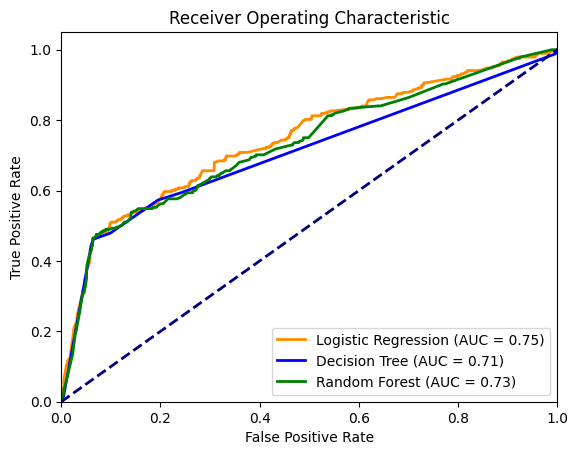

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.functions import rand
from pyspark.sql.window import Window

# Initialize Spark Session
spark = SparkSession.builder.appName("HR_Analytics").getOrCreate()

# Load Data
data = spark.read.csv("aug_train.csv", header=True, inferSchema=True)


# Drop two columns
columns_to_drop = ["company_size", "company_type"]
df_dropped = data.drop(*columns_to_drop)

# Handle Missing Values
# data = df_dropped.fillna({'gender': 'Unknown', 'major_discipline': 'Unknown', 'education_level': 'Unknown'})


# Remove Rows with Missing Values
data = data.dropna()



# Upsample the minority class
major_df = data.filter(col("target") == 0)
minor_df = data.filter(col("target") == 1)
ratio = int(major_df.count() / minor_df.count())
upsampled_minor_df = minor_df.withColumn("dummy", expr("explode(array_repeat(1, {}))".format(ratio))).drop("dummy")

# Combine the upsampled minority class with the majority class
data_upsampled = major_df.union(upsampled_minor_df)


# Feature Engineering
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'last_new_job']]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=[col+"_encoded" for col in ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'last_new_job']])
assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")

# Dimensionality Reduction using PCA
pca = PCA(k=10, inputCol="features", outputCol="pca_features")

# Models
lr = LogisticRegression(featuresCol="pca_features", labelCol="target")
dt = DecisionTreeClassifier(featuresCol="pca_features", labelCol="target")
rf = RandomForestClassifier(featuresCol="pca_features", labelCol="target")

# Pipelines
pipeline_lr = Pipeline(stages=indexers + [encoder, assembler, pca, lr])
pipeline_dt = Pipeline(stages=indexers + [encoder, assembler, pca, dt])
pipeline_rf = Pipeline(stages=indexers + [encoder, assembler, pca, rf])

# Train-Test Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


# Train Models
model_lr = pipeline_lr.fit(train_data)
model_dt = pipeline_dt.fit(train_data)
model_rf = pipeline_rf.fit(train_data)

# Make Predictions
predictions_lr = model_lr.transform(test_data)
predictions_dt = model_dt.transform(test_data)
predictions_rf = model_rf.transform(test_data)

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")

# Evaluate Models
auc_roc_lr = evaluator.evaluate(predictions_lr)
auc_roc_dt = evaluator.evaluate(predictions_dt)
auc_roc_rf = evaluator.evaluate(predictions_rf)

# Print AUC-ROC Scores for Each Model
print("Logistic Regression AUC-ROC:", auc_roc_lr)
print("Decision Tree AUC-ROC:", auc_roc_dt)
print("Random Forest AUC-ROC:", auc_roc_rf)


#===========================

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions and labels as arrays
y_true = predictions_lr.select("target").collect()
y_prob_lr = predictions_lr.select("probability").rdd.map(lambda x: x[0][1]).collect()
y_prob_dt = predictions_dt.select("probability").rdd.map(lambda x: x[0][1]).collect()
y_prob_rf = predictions_rf.select("probability").rdd.map(lambda x: x[0][1]).collect()

# Calculate ROC curves and AUC scores
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_dt, tpr_dt, _ = roc_curve(y_true, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_true, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# Close Spark Session
# spark.stop()


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Make Predictions on Train Set
train_predictions_lr = model_lr.transform(train_data)
train_predictions_dt = model_dt.transform(train_data)
train_predictions_rf = model_rf.transform(train_data)

# Convert predictions to RDD
train_predictionAndLabels_lr = train_predictions_lr.select("prediction", "target").rdd
train_predictionAndLabels_dt = train_predictions_dt.select("prediction", "target").rdd
train_predictionAndLabels_rf = train_predictions_rf.select("prediction", "target").rdd

# Initialize MulticlassMetrics for train data
train_metrics_lr = MulticlassMetrics(train_predictionAndLabels_lr)
train_metrics_dt = MulticlassMetrics(train_predictionAndLabels_dt)
train_metrics_rf = MulticlassMetrics(train_predictionAndLabels_rf)

# Calculate confusion matrix for train data for each model
train_conf_matrix_lr = train_metrics_lr.confusionMatrix().toArray()
train_conf_matrix_dt = train_metrics_dt.confusionMatrix().toArray()
train_conf_matrix_rf = train_metrics_rf.confusionMatrix().toArray()

# Display confusion matrix for train data for each model
print("Confusion Matrix - Train Data - Logistic Regression:")
print(train_conf_matrix_lr)

print("\nConfusion Matrix - Train Data - Decision Tree:")
print(train_conf_matrix_dt)

print("\nConfusion Matrix - Train Data - Random Forest:")
print(train_conf_matrix_rf)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix - Train Data - Logistic Regression:
[[5684.  356.]
 [ 689.  506.]]

Confusion Matrix - Train Data - Decision Tree:
[[5748.  292.]
 [ 716.  479.]]

Confusion Matrix - Train Data - Random Forest:
[[5771.  269.]
 [ 728.  467.]]


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Make Predictions on Train Set
train_predictions_lr = model_lr.transform(train_data)
train_predictions_dt = model_dt.transform(train_data)
train_predictions_rf = model_rf.transform(train_data)

# Convert predictions to RDD
train_predictionAndLabels_lr = train_predictions_lr.select("prediction", "target").rdd
train_predictionAndLabels_dt = train_predictions_dt.select("prediction", "target").rdd
train_predictionAndLabels_rf = train_predictions_rf.select("prediction", "target").rdd

# Initialize MulticlassMetrics for train data
train_metrics_lr = MulticlassMetrics(train_predictionAndLabels_lr)
train_metrics_dt = MulticlassMetrics(train_predictionAndLabels_dt)
train_metrics_rf = MulticlassMetrics(train_predictionAndLabels_rf)

# Calculate precision, recall, and F1-score for each label for train data
precision_train_lr = train_metrics_lr.precision(1.0)  # Replace with the appropriate label value
recall_train_lr = train_metrics_lr.recall(1.0)
f1_score_train_lr = train_metrics_lr.fMeasure(1.0)

precision_train_dt = train_metrics_dt.precision(1.0)
recall_train_dt = train_metrics_dt.recall(1.0)
f1_score_train_dt = train_metrics_dt.fMeasure(1.0)

precision_train_rf = train_metrics_rf.precision(1.0)
recall_train_rf = train_metrics_rf.recall(1.0)
f1_score_train_rf = train_metrics_rf.fMeasure(1.0)

# Display metrics for each model on train data
print("Metrics for Logistic Regression - Train Data:")
print(f"Precision: {precision_train_lr:.4f}")
print(f"Recall: {recall_train_lr:.4f}")
print(f"F1-Score: {f1_score_train_lr:.4f}")

print("\nMetrics for Decision Tree - Train Data:")
print(f"Precision: {precision_train_dt:.4f}")
print(f"Recall: {recall_train_dt:.4f}")
print(f"F1-Score: {f1_score_train_dt:.4f}")

print("\nMetrics for Random Forest - Train Data:")
print(f"Precision: {precision_train_rf:.4f}")
print(f"Recall: {recall_train_rf:.4f}")
print(f"F1-Score: {f1_score_train_rf:.4f}")


Metrics for Logistic Regression - Train Data:
Precision: 0.5870
Recall: 0.4234
F1-Score: 0.4920

Metrics for Decision Tree - Train Data:
Precision: 0.6213
Recall: 0.4008
F1-Score: 0.4873

Metrics for Random Forest - Train Data:
Precision: 0.6345
Recall: 0.3908
F1-Score: 0.4837


# New section

Logistic Regression AUC-ROC on Test Set: 0.7081914862662969
Decision Tree AUC-ROC on Test Set: 0.36058373099006824
Random Forest AUC-ROC on Test Set: 0.7076156114214774


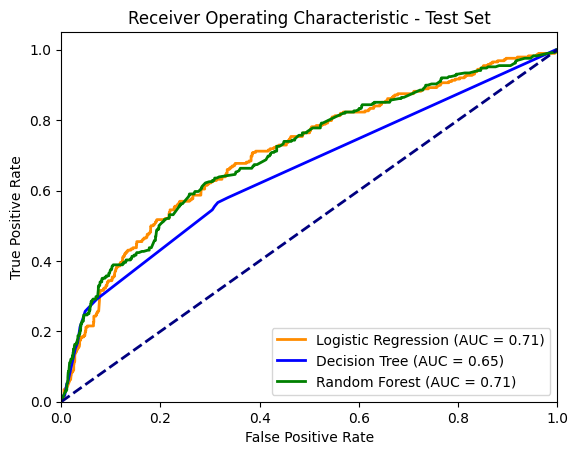

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Initialize Spark Session
spark = SparkSession.builder.appName("HR_Analytics").getOrCreate()

# Load Data
data = spark.read.csv("aug_train.csv", header=True, inferSchema=True)

# Remove Rows with Missing Values
data = data.dropna()

# Handle Missing Values
data = data.fillna({'gender': 'Unknown', 'major_discipline': 'Unknown', 'education_level': 'Unknown'})

# Feature Engineering
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=[col+"_encoded" for col in ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']])
assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")

# Dimensionality Reduction using PCA
pca = PCA(k=10, inputCol="features", outputCol="pca_features")

# Train-Test Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Models
lr = LogisticRegression(featuresCol="pca_features", labelCol="target")
dt = DecisionTreeClassifier(featuresCol="pca_features", labelCol="target")
rf = RandomForestClassifier(featuresCol="pca_features", labelCol="target")

# Pipelines
pipeline_lr = Pipeline(stages=indexers + [encoder, assembler, pca, lr])
pipeline_dt = Pipeline(stages=indexers + [encoder, assembler, pca, dt])
pipeline_rf = Pipeline(stages=indexers + [encoder, assembler, pca, rf])

# Train Models
model_lr = pipeline_lr.fit(train_data)
model_dt = pipeline_dt.fit(train_data)
model_rf = pipeline_rf.fit(train_data)

# Make Predictions on Test Set
predictions_lr = model_lr.transform(test_data)
predictions_dt = model_dt.transform(test_data)
predictions_rf = model_rf.transform(test_data)

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")

# Evaluate Models on Test Set
auc_roc_lr = evaluator.evaluate(predictions_lr)
auc_roc_dt = evaluator.evaluate(predictions_dt)
auc_roc_rf = evaluator.evaluate(predictions_rf)

# Print AUC-ROC Scores for Each Model
print("Logistic Regression AUC-ROC on Test Set:", auc_roc_lr)
print("Decision Tree AUC-ROC on Test Set:", auc_roc_dt)
print("Random Forest AUC-ROC on Test Set:", auc_roc_rf)

# Get predictions and labels as arrays for ROC curve
y_true = predictions_lr.select("target").collect()
y_prob_lr = predictions_lr.select("probability").rdd.map(lambda x: x[0][1]).collect()
y_prob_dt = predictions_dt.select("probability").rdd.map(lambda x: x[0][1]).collect()
y_prob_rf = predictions_rf.select("probability").rdd.map(lambda x: x[0][1]).collect()

# Calculate ROC curves and AUC scores
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_dt, tpr_dt, _ = roc_curve(y_true, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_true, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

# Close Spark Session
# spark.stop()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert predictions to arrays
y_pred_lr = np.array(predictions_lr.select("prediction").collect())
y_pred_dt = np.array(predictions_dt.select("prediction").collect())
y_pred_rf = np.array(predictions_rf.select("prediction").collect())

# Convert true labels to arrays
y_true = np.array(predictions_lr.select("target").collect())

# Calculate confusion matrix for each model
conf_matrix_lr = confusion_matrix(y_true, y_pred_lr)
conf_matrix_dt = confusion_matrix(y_true, y_pred_dt)
conf_matrix_rf = confusion_matrix(y_true, y_pred_rf)

# Display confusion matrix for each model
print("Confusion Matrix - Logistic Regression:")
print(conf_matrix_lr)

print("\nConfusion Matrix - Decision Tree:")
print(conf_matrix_dt)

print("\nConfusion Matrix - Random Forest:")
print(conf_matrix_rf)


Confusion Matrix - Logistic Regression:
[[1426    6]
 [ 286    2]]

Confusion Matrix - Decision Tree:
[[1378   54]
 [ 227   61]]

Confusion Matrix - Random Forest:
[[1410   22]
 [ 263   25]]


In [ ]:
# confusion matrix Training data
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert predictions to RDD
predictionAndLabels_lr = predictions_lr.select("prediction", "target").rdd
predictionAndLabels_dt = predictions_dt.select("prediction", "target").rdd
predictionAndLabels_rf = predictions_rf.select("prediction", "target").rdd

# Initialize MulticlassMetrics
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
metrics_dt = MulticlassMetrics(predictionAndLabels_dt)
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)

# Calculate confusion matrix for each model
conf_matrix_lr = metrics_lr.confusionMatrix().toArray()
conf_matrix_dt = metrics_dt.confusionMatrix().toArray()
conf_matrix_rf = metrics_rf.confusionMatrix().toArray()

# Display confusion matrix for each model
print("Confusion Matrix - Logistic Regression:")
print(conf_matrix_lr)

print("\nConfusion Matrix - Decision Tree:")
print(conf_matrix_dt)

print("\nConfusion Matrix - Random Forest:")
print(conf_matrix_rf)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix - Logistic Regression:
[[1426.    6.]
 [ 286.    2.]]

Confusion Matrix - Decision Tree:
[[1378.   54.]
 [ 227.   61.]]

Confusion Matrix - Random Forest:
[[1410.   22.]
 [ 263.   25.]]


In [ ]:
# confusion matrix Training data
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert predictions to RDD
predictionAndLabels_lr = predictions_lr.select("prediction", "target").rdd
predictionAndLabels_dt = predictions_dt.select("prediction", "target").rdd
predictionAndLabels_rf = predictions_rf.select("prediction", "target").rdd

# Initialize MulticlassMetrics
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
metrics_dt = MulticlassMetrics(predictionAndLabels_dt)
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)

# Calculate precision, recall, f1-score, and other metrics for each label
precision_lr = metrics_lr.precision(1.0)  # Replace with the appropriate label value
recall_lr = metrics_lr.recall(1.0)
f1_score_lr = metrics_lr.fMeasure(1.0)

precision_dt = metrics_dt.precision(1.0)
recall_dt = metrics_dt.recall(1.0)
f1_score_dt = metrics_dt.fMeasure(1.0)

precision_rf = metrics_rf.precision(1.0)
recall_rf = metrics_rf.recall(1.0)
f1_score_rf = metrics_rf.fMeasure(1.0)

# Print metrics for each model
print("Metrics for Logistic Regression:")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_score_lr:.4f}")

print("\nMetrics for Decision Tree:")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")

print("\nMetrics for Random Forest:")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_score_rf:.4f}")


Metrics for Logistic Regression:
Precision: 0.2500
Recall: 0.0069
F1-Score: 0.0135

Metrics for Decision Tree:
Precision: 0.5304
Recall: 0.2118
F1-Score: 0.3027

Metrics for Random Forest:
Precision: 0.5319
Recall: 0.0868
F1-Score: 0.1493
